In [221]:
import pandas as pd
import numpy as np
import re
import string
import gensim
import nltk

from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.utils import simple_preprocess


In [222]:
lemmatizer = WordNetLemmatizer()

In [223]:
df = pd.read_csv("Hotel_Reviews.csv")

In [224]:
# Reviewer_Nationality 값 확인
df['Reviewer_Nationality'].unique()

array([' Russia ', ' Ireland ', ' Australia ', ' United Kingdom ',
       ' New Zealand ', ' Poland ', ' Belgium ', ' Norway ', ' France ',
       ' Italy ', ' Canada ', ' Netherlands ', ' Germany ',
       ' United States of America ', ' Hungary ', ' Israel ',
       ' Switzerland ', ' India ', ' United Arab Emirates ', ' Malaysia ',
       ' Denmark ', ' South Africa ', ' Rwanda ', ' Finland ',
       ' Portugal ', ' Luxembourg ', ' Spain ', ' Malta ', ' China ',
       ' Turkey ', ' Ukraine ', ' Gibraltar ', ' Argentina ',
       ' Abkhazia Georgia ', ' Isle of Man ', ' Sweden ', ' Croatia ',
       ' Saudi Arabia ', ' Lithuania ', ' Slovenia ', ' Panama ',
       ' Austria ', ' Brazil ', ' Taiwan ', ' Iceland ', ' Iran ',
       ' Liechtenstein ', ' Chile ', ' Hong Kong ',
       ' United States Minor Outlying Islands ', ' Morocco ', ' Oman ',
       ' Lebanon ', ' Qatar ', ' Nigeria ', ' Romania ',
       ' Czech Republic ', ' Greece ', ' Thailand ', ' Singapore ',
       ' Guerns

In [225]:
print(df.describe())
print(df['Reviewer_Nationality'].value_counts())

       Additional_Number_of_Scoring  Average_Score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                           

In [226]:
# select reviews nationality in united states of america
df = df[df['Reviewer_Nationality'] == ' United States of America ']

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35437 entries, 25 to 515709
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Hotel_Address                               35437 non-null  object 
 1   Additional_Number_of_Scoring                35437 non-null  int64  
 2   Review_Date                                 35437 non-null  object 
 3   Average_Score                               35437 non-null  float64
 4   Hotel_Name                                  35437 non-null  object 
 5   Reviewer_Nationality                        35437 non-null  object 
 6   Negative_Review                             35437 non-null  object 
 7   Review_Total_Negative_Word_Counts           35437 non-null  int64  
 8   Total_Number_of_Reviews                     35437 non-null  int64  
 9   Positive_Review                             35437 non-null  object 
 10  Review_T

In [228]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
25,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/25/2017,7.7,Hotel Arena,United States of America,The bathroom in our room was a black glass bo...,57,1403,Great location in the park near museums and r...,43,4,8.3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",70 days,52.360576,4.915968
28,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/21/2017,7.7,Hotel Arena,United States of America,We had 2 different rooms here and both were d...,53,1403,The hotel itself is beautiful restaurant is v...,22,4,8.3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",74 days,52.360576,4.915968
32,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/11/2017,7.7,Hotel Arena,United States of America,Our bathroom had an urine order Shower was ve...,68,1403,No Positive,0,1,4.2,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",84 days,52.360576,4.915968
34,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/2/2017,7.7,Hotel Arena,United States of America,The rooms were cold Although nice the room de...,26,1403,The room was very big spacious The bath tub w...,32,6,7.9,"[' Leisure trip ', ' Family with young childre...",93 days,52.360576,4.915968
44,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,4/5/2017,7.7,Hotel Arena,United States of America,The service was awful They refused to take ow...,26,1403,The brunch to purchase in the morning was good,11,1,3.3,"[' Leisure trip ', ' Group ', ' Large King Roo...",120 day,52.360576,4.915968


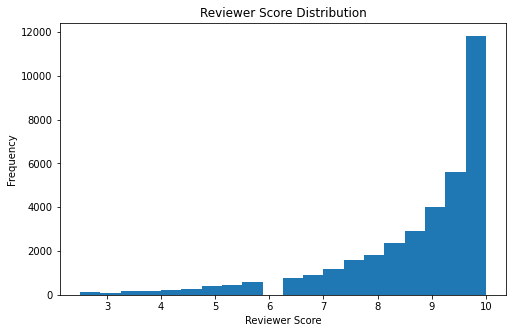

In [229]:
df['Reviewer_Score'].plot(kind='hist', bins=20, title='Reviewer Score Distribution', figsize=(8, 5))
plt.xlabel('Reviewer Score')
plt.show()

In [230]:
def set_stop_words(extended_words):
    stop_words = stopwords.words('english')
    stop_words.extend(extended_words)
    return stop_words

extended_words = ['cant', 'im', 'ive']
stop_words = set_stop_words(extended_words)

In [231]:
# 텍스트 전처리 함수
def preprocess_text(text_data,get_lemma=True, tags=(), stop_words=[]):
    # 소문자 변경
    text_data = text_data.lower()
    # URL 제거
    text_data = re.sub(r'((www.\S+)|(https?://\S+))', r"", text_data)
    # HTML 태그 제거
    text_data = re.sub(r'<[^>]+>', r'', text_data)
    # 숫자 제거
    text_data = re.sub(r'[0-9]\S+', r'', text_data)
    # 문장부호 제거
    text_data = [char for char in text_data if char not in string.punctuation]
    text_data = "".join(text_data)
    # 금지어 제거
    text_data = [word for word in text_data.split() if word.lower() not in stop_words]
    text_data = " ".join(text_data)
    # 래마타이즈
    if get_lemma==True:
        text_data = [lemmatizer.lemmatize(word) for word in text_data.split()]
        text_data = " ".join(text_data)
    # POS 필터 
    if len(tags)>0:
        text_data = [word for word, pos in nltk.pos_tag(nltk.word_tokenize(text_data)) if pos.startswith(tags)]
        text_data = " ".join(text_data)

    return text_data

In [232]:
# gensim의 simple_preprocess를 이용하여 전처리
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

In [233]:
# N-gram 전처리
def process_ngram(data_words):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
    data_words = [bigram_mod[doc] for doc in data_words]
    data_words = [trigram_mod[bigram_mod[doc]] for doc in data_words]
    
    return data_words

In [234]:
# 카운터 기반 사전 필터링
def filter_dictionary_by_count(min_count, documents, dictionary):
    from collections import Counter
    word_counter = Counter((word for words in documents for word in words))
    removal_word_idxs = {
        dictionary.token2id[word] for word, count in word_counter.items() if count < min_count
    }
    dictionary.filter_tokens(bad_ids=removal_word_idxs)
    dictionary.compactify()
    print('dictionary size: %d', len(dictionary))
    return dictionary

In [235]:
TAGS = ("JJ", "NN", "RB", "VB")
stop_words = set_stop_words(extended_words)

df['Negative_Review'] = df.apply(lambda x: preprocess_text(x['Negative_Review'], 
                                                         get_lemma=True, 
                                                         tags=TAGS,
                                                         stop_words=stop_words), 
                                                         axis=1)

df['Positive_Review'] = df.apply(lambda x: preprocess_text(x['Positive_Review'], 
                                                         get_lemma=True, 
                                                         tags=TAGS,
                                                         stop_words=stop_words), 
                                                         axis=1)

In [236]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
25,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/25/2017,7.7,Hotel Arena,United States of America,bathroom room black glass box theory cool prac...,57,1403,great location park museum restaurant perfect ...,43,4,8.3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",70 days,52.360576,4.915968
28,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/21/2017,7.7,Hotel Arena,United States of America,different room duplex identical floorplans lit...,53,1403,hotel beautiful restaurant good adjacent park ...,22,4,8.3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",74 days,52.360576,4.915968
32,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/11/2017,7.7,Hotel Arena,United States of America,bathroom urine order shower slippery shower ch...,68,1403,positive,0,1,4.2,"[' Leisure trip ', ' Group ', ' Duplex Twin Ro...",84 days,52.360576,4.915968
34,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,5/2/2017,7.7,Hotel Arena,United States of America,room cold nice room decor basic unwelcoming us...,26,1403,room big spacious bath tub large enough people...,32,6,7.9,"[' Leisure trip ', ' Family with young childre...",93 days,52.360576,4.915968
44,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,4/5/2017,7.7,Hotel Arena,United States of America,service awful refused take ownership mistake p...,26,1403,brunch purchase morning good,11,1,3.3,"[' Leisure trip ', ' Group ', ' Large King Roo...",120 day,52.360576,4.915968


In [237]:
# 리스트로 변환
negative_reviews = df['Negative_Review'].values.tolist()
positive_reviews = df['Positive_Review'].values.tolist()
negative_words = list(sent_to_words(negative_reviews))
negative_words = [doc for doc in negative_words if len(doc)>0]
positive_words = list(sent_to_words(positive_reviews))
positive_words = [doc for doc in positive_words if len(doc)>0]

print(len(negative_words))
print(len(positive_words))
print(negative_words[0])
print(positive_words[0])
print(len(negative_words[0]))
print(len(positive_words[0]))

35252
35405
['bathroom', 'room', 'black', 'glass', 'box', 'theory', 'cool', 'practice', 'leaf', 'lot', 'desired', 'little', 'privacy', 'enough', 'light', 'mirror', 'shower', 'leaked', 'hall', 'however', 'allow', 'loft', 'space', 'desk', 'chair', 'second', 'tv']
['great', 'location', 'park', 'museum', 'restaurant', 'perfect', 'launch', 'pad', 'many', 'walking', 'day', 'trip', 'beautiful', 'old', 'building', 'former', 'orphanage', 'spacious', 'room', 'big', 'breakfast', 'spread', 'perfect', 'starting', 'day', 'right', 'friendly', 'helpful', 'staff']
27
29


In [238]:
negative_docs = process_ngram(negative_words)
positive_docs = process_ngram(positive_words)

In [239]:
# Gensim 모델링을 위한 Dictionary 세트 준비
negative_dictionary = Dictionary(negative_docs)
for i in range(0, 10):
    print(negative_dictionary.get(i))

allow
bathroom
black
box
chair
cool
desired
desk
enough
glass


In [240]:
positive_dictionary = Dictionary(positive_docs)
for i in range(0, 10):
    print(positive_dictionary.get(i))

beautiful
big
breakfast
building
day
former
friendly
great
helpful
launch


In [241]:
negative_dictionary = filter_dictionary_by_count(10, negative_docs, negative_dictionary)
positive_dictionary = filter_dictionary_by_count(10, positive_docs, positive_dictionary)

dictionary size: %d 2705
dictionary size: %d 2534


In [242]:
# 말뭉치 생성 : Term Document Frequency
negative_corpus = [negative_dictionary.doc2bow(doc) for doc in negative_docs]
print(negative_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


In [243]:
positive_corpus = [positive_dictionary.doc2bow(doc) for doc in positive_docs]
print(positive_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]


In [244]:
# Coherence를 활용한 최적화
def compute_coherence_values(dictionary, corpus, texts, k_values, passes_list):
    results = []
    for num_topics in k_values:
        for passes in passes_list:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=dictionary,
                                                        num_topics=num_topics, 
                                                        random_state=42,
                                                        passes=passes,
                                                        )
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            results.append((num_topics, passes, coherence_score))
            print(f'Topics: {num_topics}, Passes: {passes}, Coherence: {coherence_score:.4f}')
    return results

In [250]:
k_values = range(2, 12, 2)  # 토픽 수
passes_list = [10, 20, 30]  # 반복 수

negative_coherence_values = compute_coherence_values(dictionary=negative_dictionary, corpus=negative_corpus, texts=negative_docs, k_values=k_values, passes_list=passes_list)

Topics: 2, Passes: 10, Coherence: 0.6674
Topics: 2, Passes: 20, Coherence: 0.6716
Topics: 2, Passes: 30, Coherence: 0.6679
Topics: 4, Passes: 10, Coherence: 0.6618
Topics: 4, Passes: 20, Coherence: 0.6618
Topics: 4, Passes: 30, Coherence: 0.6618
Topics: 6, Passes: 10, Coherence: 0.6986
Topics: 6, Passes: 20, Coherence: 0.7002
Topics: 6, Passes: 30, Coherence: 0.7002
Topics: 8, Passes: 10, Coherence: 0.6792
Topics: 8, Passes: 20, Coherence: 0.6790
Topics: 8, Passes: 30, Coherence: 0.6801
Topics: 10, Passes: 10, Coherence: 0.6948
Topics: 10, Passes: 20, Coherence: 0.6951
Topics: 10, Passes: 30, Coherence: 0.6942


In [251]:
positive_coherence_values = compute_coherence_values(dictionary=positive_dictionary, corpus=positive_corpus, texts=positive_docs, k_values=k_values, passes_list=passes_list)

Topics: 2, Passes: 10, Coherence: 0.5695
Topics: 2, Passes: 20, Coherence: 0.5963
Topics: 2, Passes: 30, Coherence: 0.6155
Topics: 4, Passes: 10, Coherence: 0.6358
Topics: 4, Passes: 20, Coherence: 0.6359
Topics: 4, Passes: 30, Coherence: 0.6374
Topics: 6, Passes: 10, Coherence: 0.6400
Topics: 6, Passes: 20, Coherence: 0.6506
Topics: 6, Passes: 30, Coherence: 0.6510
Topics: 8, Passes: 10, Coherence: 0.6411
Topics: 8, Passes: 20, Coherence: 0.6446
Topics: 8, Passes: 30, Coherence: 0.6459
Topics: 10, Passes: 10, Coherence: 0.6371
Topics: 10, Passes: 20, Coherence: 0.6355
Topics: 10, Passes: 30, Coherence: 0.6374


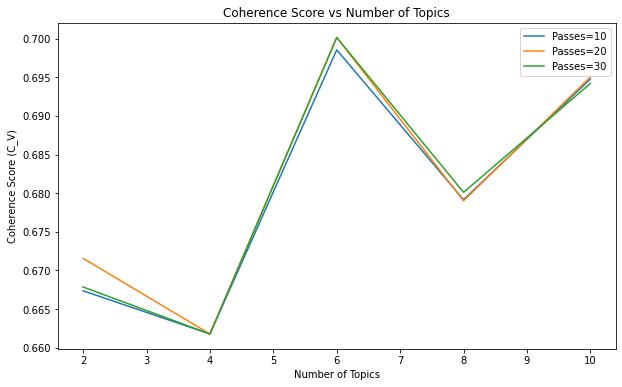

In [258]:
# 부정 리뷰 결과
ncvr_df = pd.DataFrame(negative_coherence_values, columns=["Num_Topics", "Passes", "Coherence"])

# 결과 시각화
plt.figure(figsize=(10, 6))
for passes in passes_list:
    subset = ncvr_df[ncvr_df["Passes"] == passes]
    plt.plot(subset["Num_Topics"], subset["Coherence"],
label=f'Passes={passes}')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_V)')
plt.legend()
plt.show()

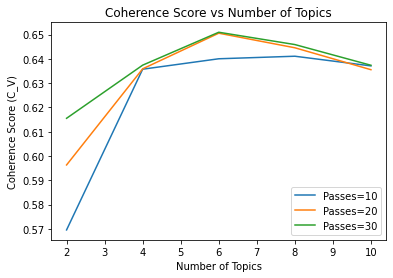

In [260]:
# 긍정 리뷰 결과
pcvr_df = pd.DataFrame(positive_coherence_values, columns=["Num_Topics", "Passes", "Coherence"])

# 결과 시각화
for passes in passes_list:
    subset = pcvr_df[pcvr_df["Passes"] == passes]
    plt.plot(subset["Num_Topics"], subset["Coherence"],
label=f'Passes={passes}')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_V)')
plt.legend()
plt.show()

In [261]:
# 최적화 결과 검증
optimal_num_topics = 6
optimal_passes = 30

negative_lda_model = LdaModel(corpus=negative_corpus,
                            id2word=negative_dictionary,
                            num_topics=optimal_num_topics,
                            random_state=42,
                            passes=optimal_passes)

positive_lda_model = LdaModel(corpus=positive_corpus,
                            id2word=positive_dictionary,
                            num_topics=optimal_num_topics,
                            random_state=42,
                            passes=optimal_passes)

In [262]:
for idx, topic in negative_lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

Topic: 0 
Words: 0.718*"negative" + 0.015*"none" + 0.008*"party" + 0.007*"smoke" + 0.006*"smoking" + 0.005*"spotty" + 0.005*"closer" + 0.004*"till" + 0.004*"happen" + 0.003*"example"
Topic: 1 
Words: 0.055*"bed" + 0.036*"location" + 0.033*"little" + 0.033*"great" + 0.030*"bit" + 0.028*"everything" + 0.025*"good" + 0.021*"area" + 0.019*"hotel" + 0.018*"pool"
Topic: 2 
Words: 0.060*"room" + 0.030*"night" + 0.026*"hotel" + 0.020*"window" + 0.018*"street" + 0.018*"noise" + 0.015*"view" + 0.014*"open" + 0.013*"door" + 0.011*"floor"
Topic: 3 
Words: 0.055*"room" + 0.026*"wifi" + 0.023*"work" + 0.021*"elevator" + 0.018*"day" + 0.017*"need" + 0.017*"time" + 0.015*"slow" + 0.015*"poor" + 0.013*"desk"
Topic: 4 
Words: 0.037*"hotel" + 0.029*"breakfast" + 0.023*"nothing" + 0.023*"staff" + 0.015*"room" + 0.009*"stay" + 0.009*"check" + 0.009*"day" + 0.008*"get" + 0.008*"desk"
Topic: 5 
Words: 0.130*"room" + 0.054*"small" + 0.039*"bathroom" + 0.037*"shower" + 0.017*"water" + 0.015*"little" + 0.014*"b

In [263]:
for idx, topic in positive_lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')

Topic: 0 
Words: 0.188*"staff" + 0.094*"helpful" + 0.066*"friendly" + 0.026*"excellent" + 0.025*"desk" + 0.024*"front" + 0.016*"wonderful" + 0.016*"extremely" + 0.014*"stay" + 0.013*"hotel"
Topic: 1 
Words: 0.178*"breakfast" + 0.098*"good" + 0.062*"location" + 0.060*"excellent" + 0.044*"positive" + 0.042*"great" + 0.034*"service" + 0.026*"food" + 0.025*"nice" + 0.024*"buffet"
Topic: 2 
Words: 0.124*"room" + 0.062*"comfortable" + 0.061*"clean" + 0.054*"nice" + 0.050*"staff" + 0.048*"bed" + 0.028*"location" + 0.027*"great" + 0.023*"modern" + 0.022*"bathroom"
Topic: 3 
Words: 0.048*"hotel" + 0.027*"room" + 0.018*"stay" + 0.011*"day" + 0.010*"get" + 0.010*"minute" + 0.010*"also" + 0.009*"night" + 0.009*"best" + 0.009*"time"
Topic: 4 
Words: 0.177*"location" + 0.114*"great" + 0.056*"everything" + 0.051*"hotel" + 0.047*"beautiful" + 0.045*"loved" + 0.043*"view" + 0.040*"perfect" + 0.029*"amazing" + 0.029*"room"
Topic: 5 
Words: 0.066*"location" + 0.052*"close" + 0.046*"station" + 0.036*"rest

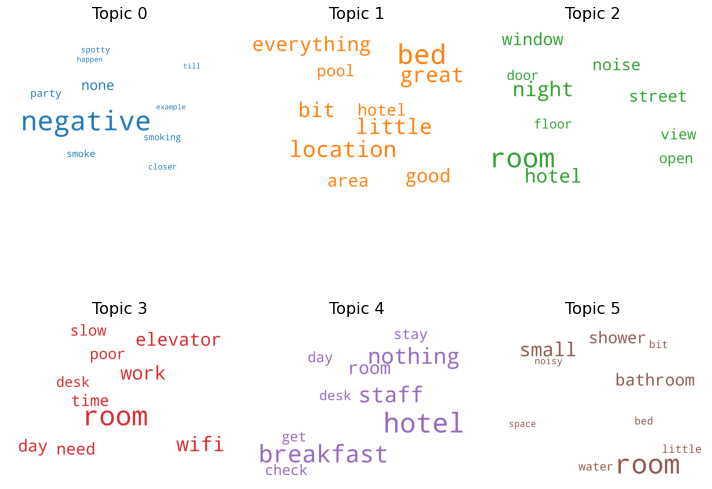

In [264]:
# wordcloud 생성
from wordcloud import WordCloud
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words, 
                  background_color='white', 
                  width=2500, 
                  height=1800, 
                  max_words=10, 
                  colormap='tab10', 
                  color_func=lambda *args, **kwargs: cols[i], 
                  prefer_horizontal=1.0)
topics = negative_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

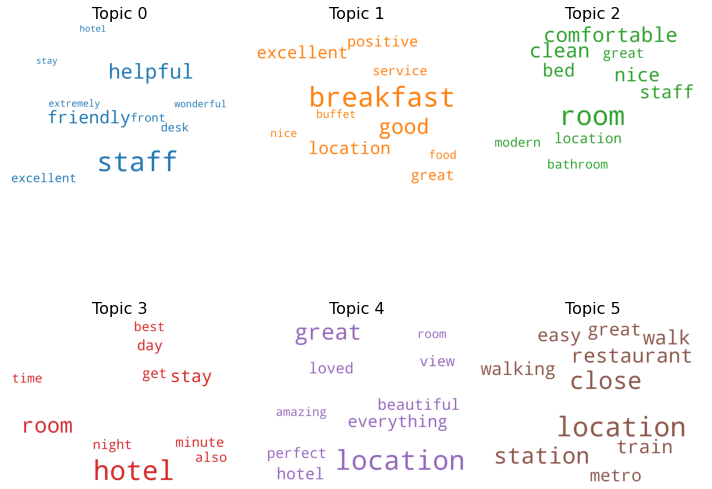

In [265]:
# wordcloud 생성
from wordcloud import WordCloud
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words, 
                  background_color='white', 
                  width=2500, 
                  height=1800, 
                  max_words=10, 
                  colormap='tab10', 
                  color_func=lambda *args, **kwargs: cols[i], 
                  prefer_horizontal=1.0)
topics = positive_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [268]:
# 결과 시각화
from collections import Counter
topics = negative_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in negative_words for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df_negative = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df_negative

,word,topic_id,importance,word_count
0,negative,0,0.718293,10541
1,none,0,0.015437,227
2,party,0,0.007800,95
3,smoke,0,0.006720,129
4,smoking,0,0.005653,130
5,spotty,0,0.004665,73
6,closer,0,0.004584,73
7,till,0,0.003746,42
8,happen,0,0.003528,53
9,example,0,0.003474,45


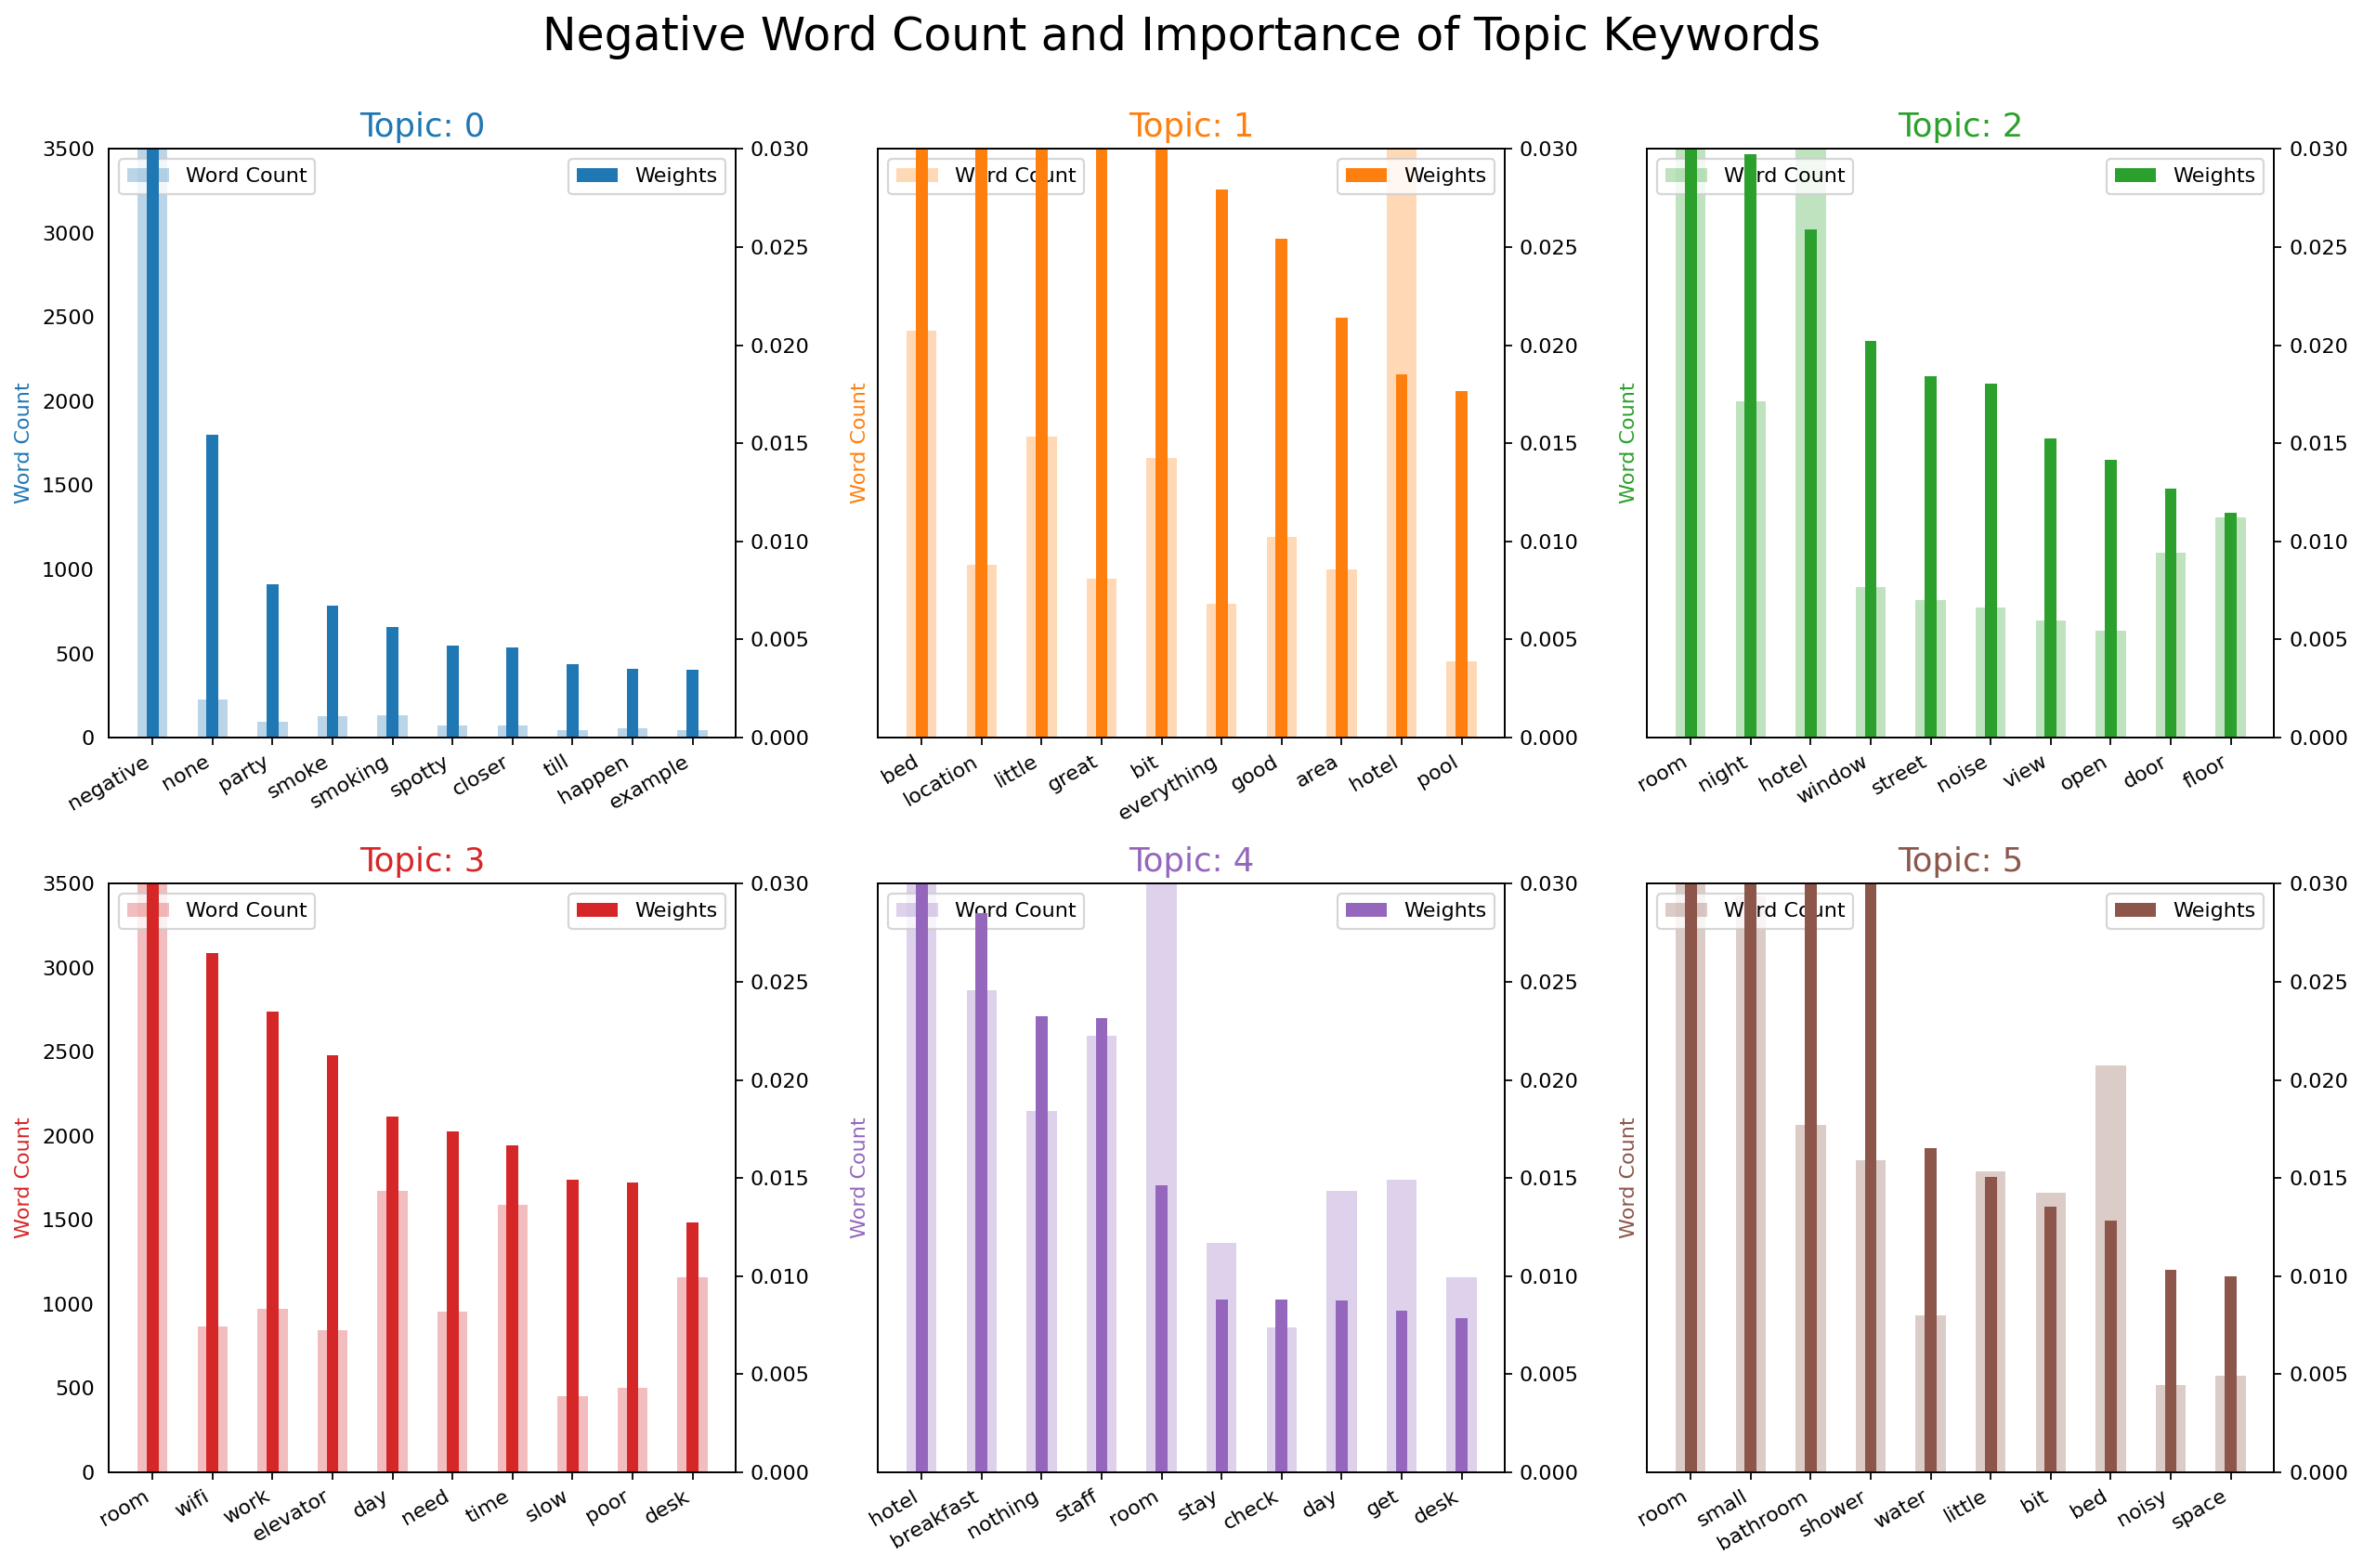

In [270]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_negative.loc[df_negative.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_negative.loc[df_negative.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_negative.loc[df_negative.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Negative Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [271]:
from collections import Counter
topics = positive_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in positive_words for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df_positive = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df_positive

,word,topic_id,importance,word_count
0,staff,0,0.187717,16209
1,helpful,0,0.093765,7033
2,friendly,0,0.065888,5732
3,excellent,0,0.026195,4449
4,desk,0,0.024537,1534
5,front,0,0.024053,1489
6,wonderful,0,0.015892,2060
7,extremely,0,0.015529,1171
8,stay,0,0.013516,2920
9,hotel,0,0.013368,10519


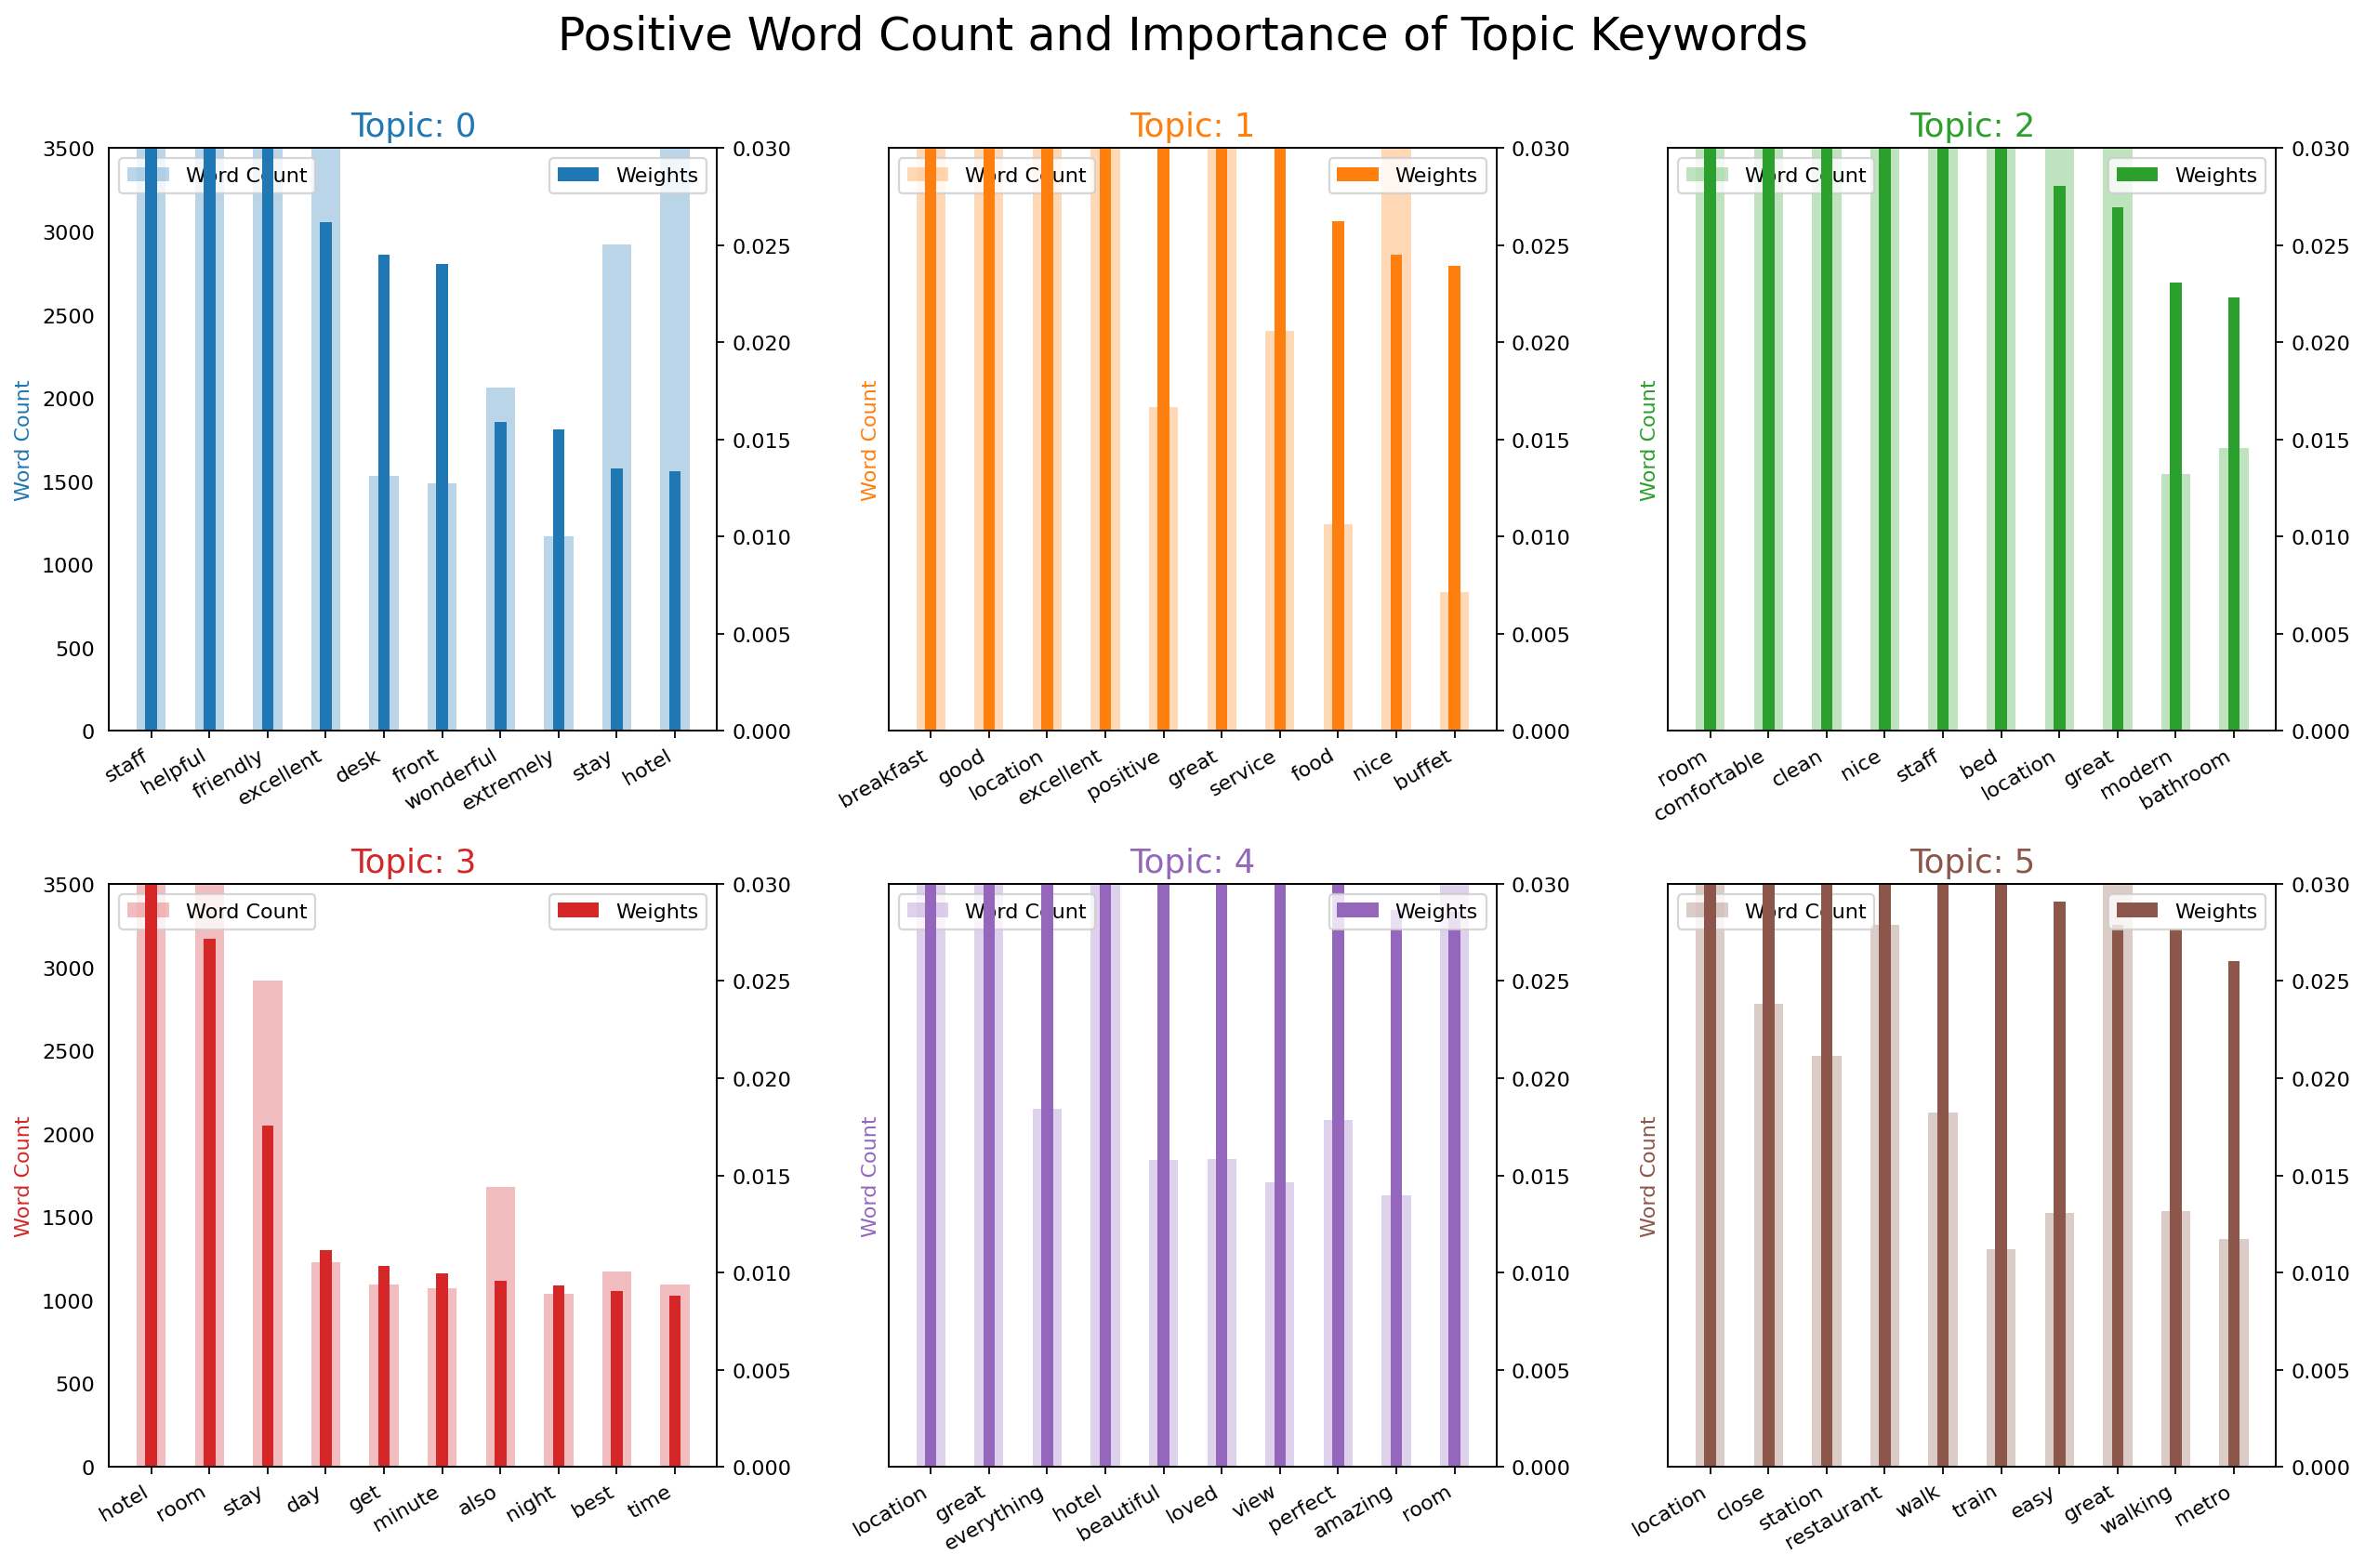

In [272]:
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_positive.loc[df_positive.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_positive.loc[df_positive.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_positive.loc[df_positive.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Positive Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [273]:
df_negative.to_csv('df_negative.csv', index=False)
df_positive.to_csv('df_positive.csv', index=False)

In [285]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
negative_tfidf = vectorizer.fit_transform(df['Negative_Review'])
positive_tfidf = vectorizer.fit_transform(df['Positive_Review'])

# TF-IDF를 합쳐서 하나의 피처로 사용
from scipy.sparse import hstack
X = hstack([negative_tfidf, positive_tfidf])

# Target 변수
y = df['Reviewer_Score']

In [286]:
from sklearn.model_selection import train_test_split

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [289]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# LightGBM 데이터셋
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 모델 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}

# LightGBM 모델 학습
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=200, early_stopping_rounds=20)

# LightGBM 예측
y_pred_lgb = lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print(f"LightGBM MSE: {mse_lgb:.4f}")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102892
[LightGBM] [Info] Number of data points in the train set: 28349, number of used features: 2000
[LightGBM] [Info] Start training from score 8.789548
[1]	training's rmse: 1.46237	valid_1's rmse: 1.46975
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 1.42134	valid_1's rmse: 1.4307
[3]	training's rmse: 1.38661	valid_1's rmse: 1.39753
[4]	training's rmse: 1.35737	valid_1's rmse: 1.37016
[5]	training's rmse: 1.33227	valid_1's rmse: 1.34733
[6]	training's rmse: 1.3108	valid_1's rmse: 1.3282
[7]	training's rmse: 1.29169	valid_1's rmse: 1.31167
[8]	training's rmse: 1.27409	valid_1's rmse: 1.29615
[9]	training's rmse: 1.25959	valid_1's rmse: 1.28354
[10]	training's rmse: 1.2451	valid_1's rmse: 1.27057

In [290]:
from sklearn.linear_model import Ridge

# Ridge Regression 모델 생성 및 학습
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Ridge 예측
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Regression MSE: {mse_ridge:.4f}")


Ridge Regression MSE: 1.2167


In [291]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 범주형 변수로 변환 (이진 분류: 점수 7 이상은 긍정, 미만은 부정)
df['Score_Category'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 7 else 0)
y_binary = df['Score_Category']

# 데이터 분할
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Logistic Regression 모델 생성 및 학습
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_bin, y_train_bin)

# Logistic Regression 예측
y_pred_logistic = logistic_model.predict(X_test_bin)
accuracy_logistic = accuracy_score(y_test_bin, y_pred_logistic)
print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}")
print(classification_report(y_test_bin, y_pred_logistic))


Logistic Regression Accuracy: 0.9087
              precision    recall  f1-score   support

           0       0.73      0.37      0.49       844
           1       0.92      0.98      0.95      6244

    accuracy                           0.91      7088
   macro avg       0.82      0.68      0.72      7088
weighted avg       0.90      0.91      0.90      7088



In [292]:
print("Model Performance Summary:")
print(f"LightGBM MSE: {mse_lgb:.4f}")
print(f"Ridge Regression MSE: {mse_ridge:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}")

Model Performance Summary:
LightGBM MSE: 1.1654
Ridge Regression MSE: 1.2167
Logistic Regression Accuracy: 0.9087


In [293]:
from sklearn.metrics import r2_score
r2_lgb = r2_score(y_test, y_pred_lgb)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'R² Score lgb: {r2_lgb}')
print(f'R² Score Ridge: {r2_ridge}')


R² Score lgb: 0.49350190466736754
R² Score Ridge: 0.4712033068199645
